In [1]:
import json
import math
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets

from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.circuit.library import PauliFeatureMap, ZFeatureMap, ZZFeatureMap

from qiskit.opflow import X, Y, Z, I, CircuitStateFn
from qiskit.opflow.state_fns import StateFn
from qiskit.opflow.expectations import PauliExpectation, MatrixExpectation
from qiskit.opflow.converters import CircuitSampler
from qiskit.providers.aer import QasmSimulator
from qiskit.quantum_info import Statevector, state_fidelity

from sklearn import datasets
from sklearn.cluster import DBSCAN, AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn import metrics

import matplotlib.cm as cm

%matplotlib inline

In [4]:
def angles_encoding(x):
    N_QBIT = math.ceil(math.log2(x.size))
    value =  math.sqrt(1/(np.sum(x.flatten()**2)))
    state_preparation = np.append(x.flatten() * value, [0] * (2**N_QBIT - x.size))

    qc = QuantumCircuit(N_QBIT, N_QBIT)
    qc.initialize(state_preparation, range(N_QBIT))

    return qc

def fidelity(x, y, encoding):
    stx = Statevector.from_instruction(encoding(x))
    sty = Statevector.from_instruction(encoding(y))
    return state_fidelity(stx, sty)


def fidelity_matrix(dataset, encoding):

    mat = np.zeros((dataset.shape[0], dataset.shape[0]))

    for i in range(dataset.shape[0]):
        for j in range(i):
            dis = fidelity(dataset[i], dataset[j], encoding)
            mat[i,j] = dis
            mat[j,i] = dis

    return mat

def euclidean_matrix(dataset):
    mat = np.zeros((dataset.shape[0], dataset.shape[0]))

    for i in range(dataset.shape[0]):
        for j in range(i):
            dis = np.sqrt(np.sum((dataset[i] - dataset[j])**2))
            mat[i,j] = dis
            mat[j,i] = dis

    return mat

In [7]:
def ag_clustering(dataset, classes, dissimilarity_matrix, linkage="complete", title=""):
    clustering = AgglomerativeClustering(affinity='precomputed', n_clusters=np.unique(classes).size,  linkage=linkage).fit(dissimilarity_matrix)

    labels = clustering.labels_
    cmap = plt.cm.get_cmap("Accent").copy()
    cmap.set_under('red')
    contingency_matrix = metrics.cluster.contingency_matrix(classes, labels)

    fig, axs = plt.subplots(1,2)
    fig.suptitle(title)
    fig.set_size_inches(15,6)

    axs[0].set_title("Contingency Matrix")
    axs[0].matshow(contingency_matrix, cmap='RdPu')
    axs[1].set_title("Predicted Clusters")
    axs[1].scatter(dataset[:,0], dataset[:,1], c=labels, cmap=cmap)


def dbscan_clustering(dataset, classes, dissimilarity_matrix, eps=0.5, min_samples=5, title=""):
    clustering = DBSCAN(eps=eps, min_samples=min_samples, metric='precomputed').fit(dissimilarity_matrix)

    labels = clustering.labels_
    cmap = plt.cm.get_cmap("Accent").copy()
    cmap.set_under('red')
    contingency_matrix = metrics.cluster.contingency_matrix(classes, labels)

    fig, axs = plt.subplots(1,2)
    fig.suptitle(title)
    fig.set_size_inches(15,6)

    axs[0].set_title("Contingency Matrix")
    axs[0].matshow(contingency_matrix, cmap='RdPu')
    axs[1].set_title("Predicted Clusters")
    axs[1].scatter(dataset[:,0], dataset[:,1], c=labels, cmap=cmap)

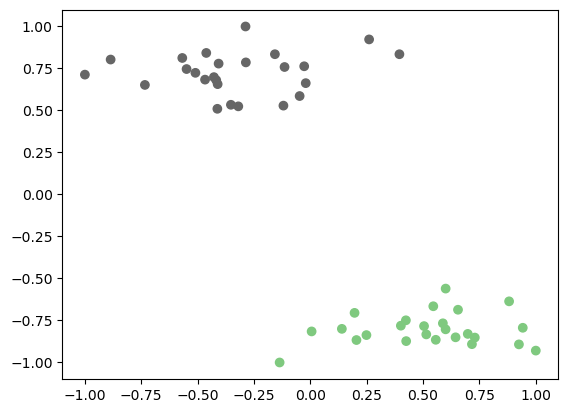

In [2]:
TRAIN_SIZE = 50

dataset, classes = datasets.make_blobs(n_samples=TRAIN_SIZE, random_state=10, centers=2, n_features=2)
dataset = np.array(dataset)
scaler = MinMaxScaler(feature_range=(-1,1))
dataset = scaler.fit_transform(dataset)

plt.scatter(dataset[:,0], dataset[:,1], c=classes, cmap="Accent")

/tmp/ipykernel_9711/3695221068.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


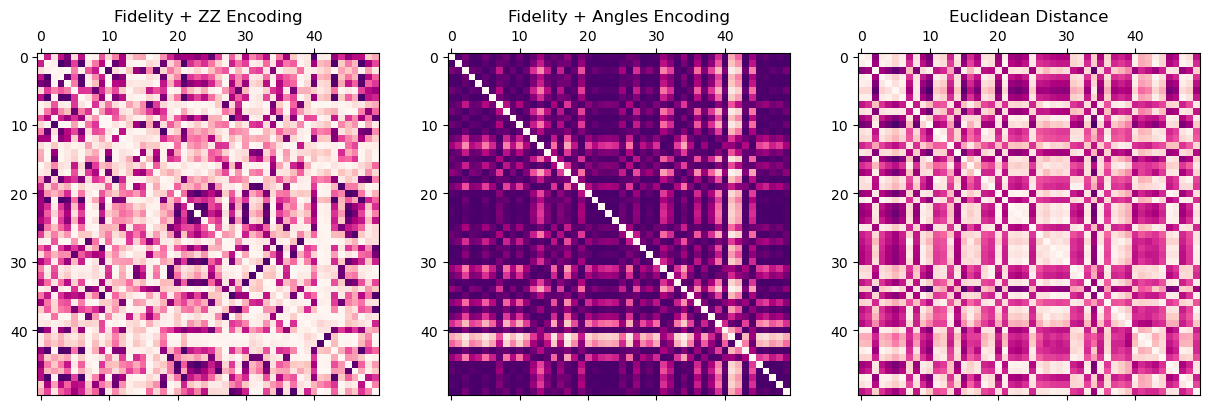

In [5]:
encode_map = ZZFeatureMap(feature_dimension=dataset.shape[1], reps=1, entanglement='linear', insert_barriers=True)

fid_ZZ = fidelity_matrix(dataset, encode_map.bind_parameters)
fid_AG = fidelity_matrix(dataset, angles_encoding)
eu_mat = euclidean_matrix(dataset)


fig, axs = plt.subplots(1,3)
fig.set_size_inches(15,6)

axs[0].matshow(fid_ZZ, cmap='RdPu')
axs[0].set_title("Fidelity + ZZ Encoding")
axs[1].matshow(fid_AG, cmap='RdPu')
axs[1].set_title("Fidelity + Angles Encoding")
axs[2].matshow(eu_mat, cmap='RdPu')
axs[2].set_title("Euclidean Distance")

fig.show()

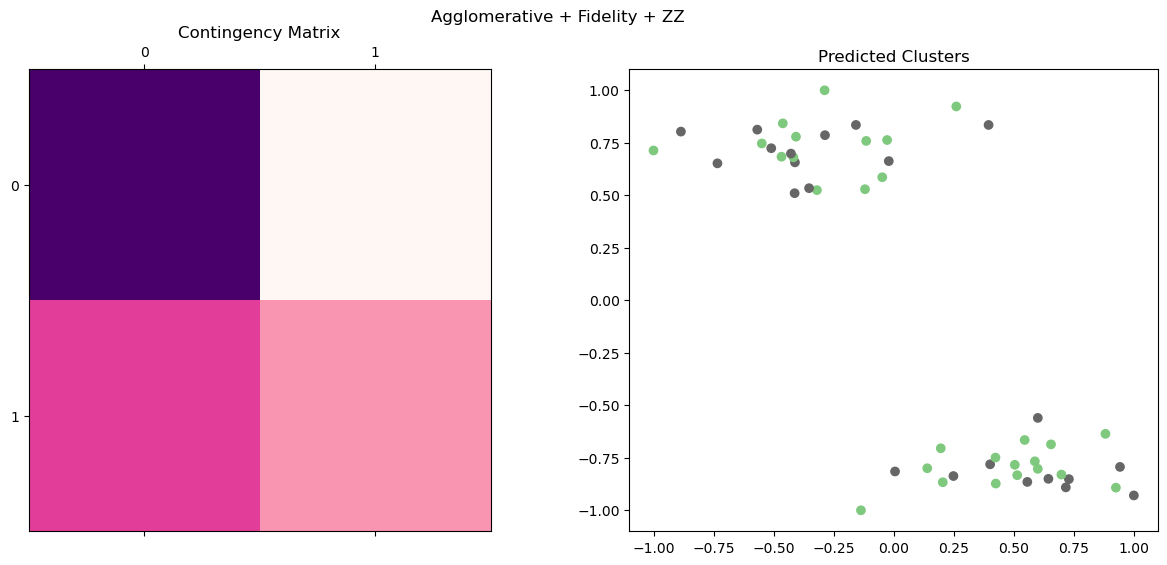

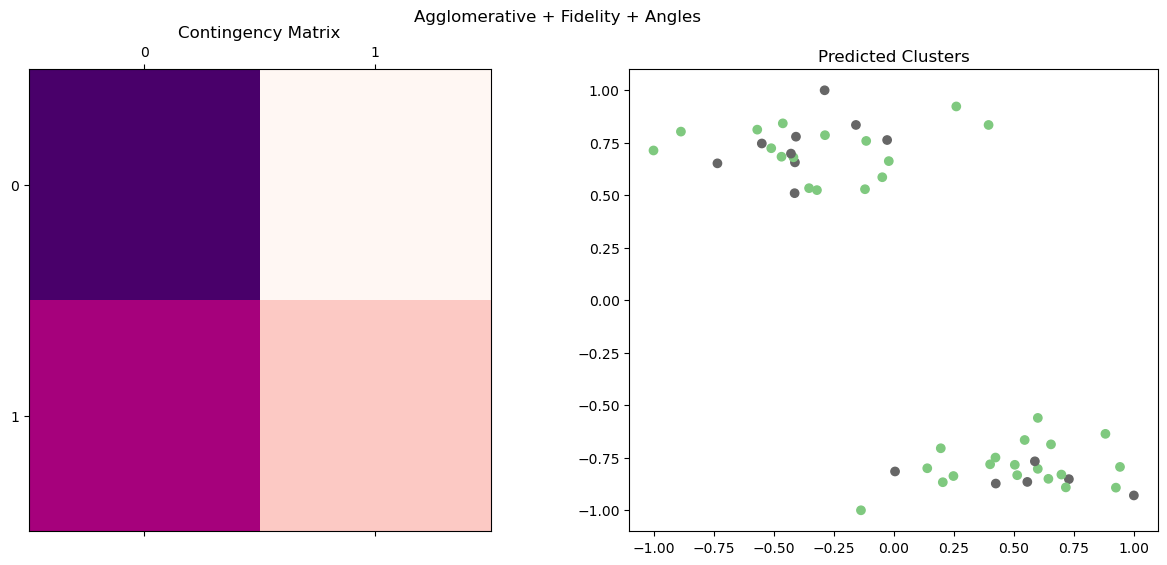

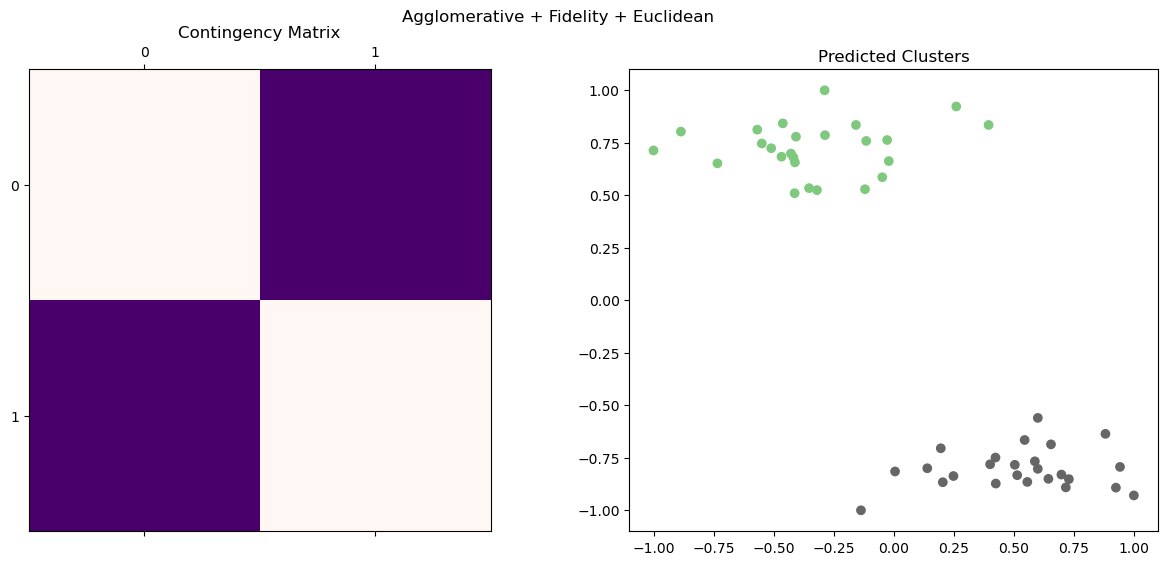

In [8]:
ag_clustering(dataset, classes, fid_ZZ, linkage="complete", title="Agglomerative + Fidelity + ZZ")
ag_clustering(dataset, classes, fid_AG, linkage="complete", title="Agglomerative + Fidelity + Angles")
ag_clustering(dataset, classes, eu_mat, linkage="complete", title="Agglomerative + Fidelity + Euclidean")